In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow
import random

# Set random seed for reproducibility
np.random.seed(0)
tensorflow.random.set_seed(0)
random.seed(0)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load and preprocess the data
df = pd.read_csv('/content/drive/MyDrive/seema/2nd_data.csv')
df.head()

,Tweet,True Label,Sub,sub_labels
0,هذا تاريخ الخبيث اللي تروجله ياوهمي متطرف اخون...,1,P-HS,0
1,في نتألم جميعا كيف اصبح حال الشعب اليمني المظل...,1,P-HS,0
2,من كان يتوقع أن السعودية التي كانت تعاقب من يف...,1,R-HS,1
3,لن نجد اخس واذل من مان يستهدفون المدنيين ويقتل...,1,S-HS,2
4,إمعة وغبي وكذاب صفات الرئيس المنتدب الفطرية,1,P-HS,0


### **Preprocessing**

In [6]:
X = df['Tweet'].astype(str)
y = df['sub_labels']

In [7]:
from tensorflow.keras.utils import to_categorical
# Convert integer labels to one-hot encoded vectors
y_cat = to_categorical(y, num_classes=3)

### **Tokenization and padding**

In [8]:
max_words = 10000  # Max number of words in tokenizer
max_len = 62  # Max sequence length
embed_dim = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

### **Word Embedding Matrix**

In [9]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz; gunzip cc.ar.300.vec.gz

--2024-05-13 07:54:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.31, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  48.9MB/s    in 24s     

2024-05-13 07:54:33 (51.1 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [10]:
# Step 1: Load FastText Model
import gensim
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format('/content/cc.ar.300.vec', binary=False)

In [11]:
# Step 2: Create Embedding Matrix from FastText
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # FastText vectors are 300-dimensional
for word, i in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_vector = fasttext_model[word]
        embedding_matrix[i] = embedding_vector

### **Models**

In [30]:
# Define a list of deep learning models to experiment with
models = [
    ('CNN', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Conv1D(128, 5, activation='relu',
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                bias_initializer=RandomNormal(mean=0.0, stddev=0.05)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ]))

]


### **Train 5 cross validation**

In [31]:
!export TF_DETERMINISTIC_OPS=1

In [32]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Training and evaluating CNN with 5-fold stratified cross-validation...
Epoch 1/100
28/28 [==============================] - 13s 425ms/step - loss: 1.0351 - accuracy: 0.4777 - val_loss: 1.0038 - val_accuracy: 0.5247
Epoch 2/100
28/28 [==============================] - 10s 341ms/step - loss: 0.9801 - accuracy: 0.5574 - val_loss: 0.9739 - val_accuracy: 0.5628
Epoch 3/100
28/28 [==============================] - 9s 308ms/step - loss: 0.9470 - accuracy: 0.5969 - val_loss: 0.9504 - val_accuracy: 0.5930
Epoch 4/100
28/28 [==============================] - 8s 302ms/step - loss: 0.9167 - accuracy: 0.6213 - val_loss: 0.9259 - val_accuracy: 0.6065
Epoch 5/100
28/28 [==============================] - 8s 288ms/step - loss: 0.8874 - accuracy: 0.6412 - val_loss: 0.9059 - val_accuracy: 0.6188
Epoch 6/100
28/28 [==============================] - 8s 301ms/step - loss: 0.8586 - accuracy: 0.6539 - val_loss: 0.8860 - val_accuracy: 0.6278
Epoch 7/100
28/28 [==============================] - 8s 272ms/step - 

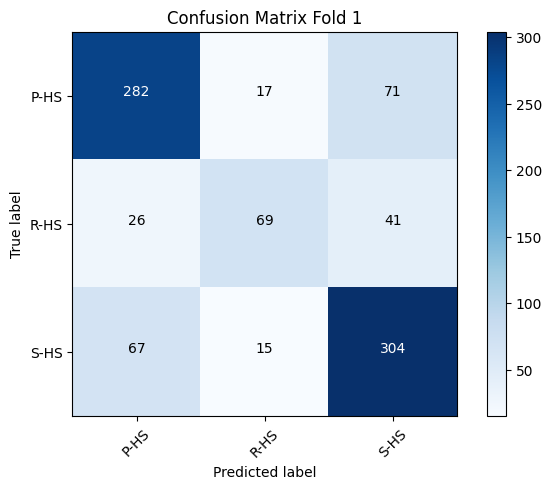

              precision    recall  f1-score   support

        P-HS       0.75      0.76      0.76       370
        R-HS       0.68      0.51      0.58       136
        S-HS       0.73      0.79      0.76       386

    accuracy                           0.73       892
   macro avg       0.72      0.69      0.70       892
weighted avg       0.73      0.73      0.73       892

Epoch 1/100
28/28 [==============================] - 12s 393ms/step - loss: 0.3176 - accuracy: 0.9094 - val_loss: 0.2101 - val_accuracy: 0.9720
Epoch 2/100
28/28 [==============================] - 8s 290ms/step - loss: 0.2945 - accuracy: 0.9206 - val_loss: 0.2108 - val_accuracy: 0.9709
Epoch 3/100
28/28 [==============================] - 9s 327ms/step - loss: 0.2783 - accuracy: 0.9268 - val_loss: 0.2094 - val_accuracy: 0.9675
Epoch 4/100
28/28 [==============================] - 6s 199ms/step - loss: 0.2626 - accuracy: 0.9338 - val_loss: 0.2086 - val_accuracy: 0.9664
Epoch 5/100
28/28 [===========================

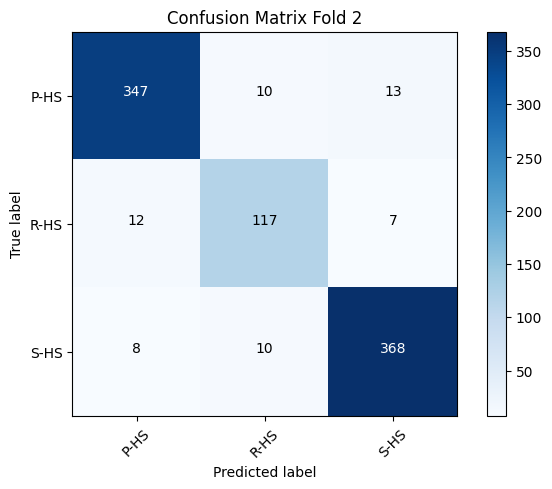

              precision    recall  f1-score   support

        P-HS       0.95      0.94      0.94       370
        R-HS       0.85      0.86      0.86       136
        S-HS       0.95      0.95      0.95       386

    accuracy                           0.93       892
   macro avg       0.92      0.92      0.92       892
weighted avg       0.93      0.93      0.93       892

Epoch 1/100
28/28 [==============================] - 12s 369ms/step - loss: 0.0728 - accuracy: 0.9851 - val_loss: 0.0384 - val_accuracy: 0.9966
Epoch 2/100
28/28 [==============================] - 7s 247ms/step - loss: 0.0598 - accuracy: 0.9913 - val_loss: 0.0391 - val_accuracy: 0.9955
Epoch 3/100
28/28 [==============================] - 4s 152ms/step - loss: 0.0520 - accuracy: 0.9947 - val_loss: 0.0398 - val_accuracy: 0.9955
Epoch 4/100
28/28 [==============================] - 4s 139ms/step - loss: 0.0466 - accuracy: 0.9972 - val_loss: 0.0398 - val_accuracy: 0.9955
Epoch 5/100
28/28 [===========================

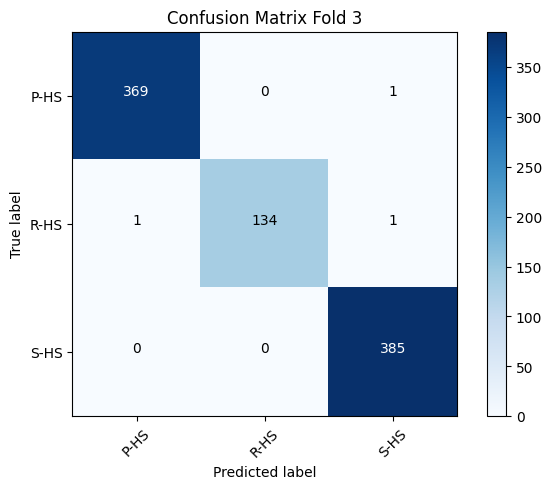

              precision    recall  f1-score   support

        P-HS       1.00      1.00      1.00       370
        R-HS       1.00      0.99      0.99       136
        S-HS       0.99      1.00      1.00       385

    accuracy                           1.00       891
   macro avg       1.00      0.99      1.00       891
weighted avg       1.00      1.00      1.00       891

Epoch 1/100
28/28 [==============================] - 11s 360ms/step - loss: 0.0649 - accuracy: 0.9896 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 2/100
28/28 [==============================] - 8s 282ms/step - loss: 0.0544 - accuracy: 0.9944 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 3/100
28/28 [==============================] - 5s 186ms/step - loss: 0.0479 - accuracy: 0.9964 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 4/100
28/28 [==============================] - 4s 139ms/step - loss: 0.0430 - accuracy: 0.9978 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 5/100
28/28 [===========================

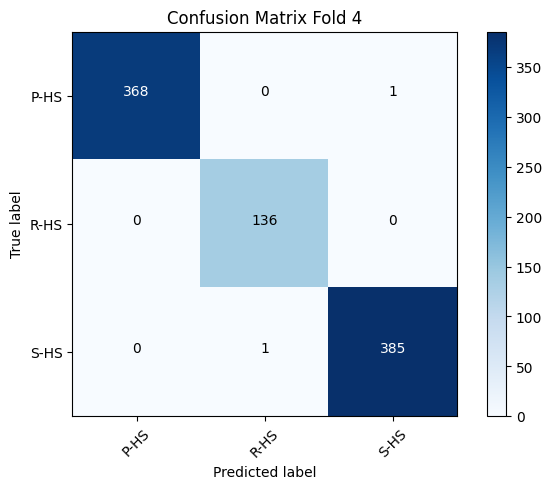

              precision    recall  f1-score   support

        P-HS       1.00      1.00      1.00       369
        R-HS       0.99      1.00      1.00       136
        S-HS       1.00      1.00      1.00       386

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891

Epoch 1/100
28/28 [==============================] - 10s 331ms/step - loss: 0.0094 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 2/100
28/28 [==============================] - 7s 262ms/step - loss: 0.0073 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 3/100
28/28 [==============================] - 8s 274ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/100
28/28 [==============================] - 8s 290ms/step - loss: 0.0057 - accuracy: 0.9997 - val_loss: 0.0034 - val_accuracy: 0.9989
Epoch 5/100
28/28 [===========================

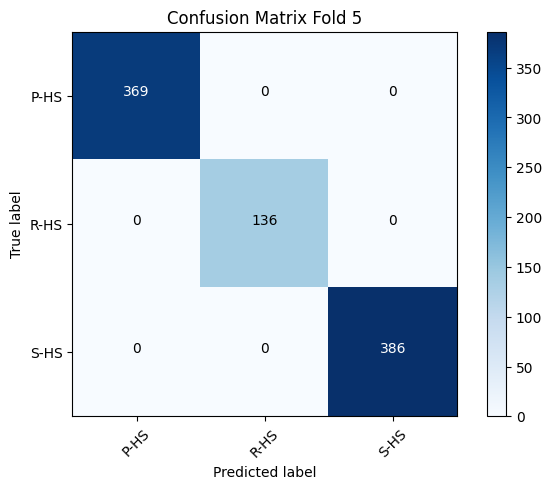

              precision    recall  f1-score   support

        P-HS       1.00      1.00      1.00       369
        R-HS       1.00      1.00      1.00       136
        S-HS       1.00      1.00      1.00       386

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891

Average metrics for CNN:
Average Accuracy: 0.9323
Average Precision: 0.9264
Average Recall: 0.9191
Average F1 Score: 0.9218



In [33]:
# Stratified cross-validation with 10 folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'history'])

output_dir = '/content/drive/MyDrive/seema'
# Training and evaluation loop for each model
for name, model in models:
    print(f'Training and evaluating {name} with {n_splits}-fold stratified cross-validation...')
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_pad, y), 1):
        X_train, X_val = X_pad[train_idx], X_pad[val_idx]
        y_train, y_val = y_cat[train_idx], y_cat[val_idx]
        y_val_ =  y[val_idx]
        val_texts = df.iloc[val_idx]['Tweet'].tolist()
        val_subs = df.iloc[val_idx]['Sub'].tolist()
        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

        # Define callbacks (checkpoint and early stopping)
        checkpoint = ModelCheckpoint(f'{output_dir}/checkpoints/cnn/non_trainable/{name}_fold{fold_idx}.h5', monitor='val_loss', save_best_only=True, verbose=0)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

        # Train the model with callbacks
        history = model.fit(X_train, y_train, epochs=100, batch_size=128,
                            validation_data=(X_val, y_val),
                            callbacks=[checkpoint, early_stopping],
                            verbose=1)

        # Load the best model for prediction
        best_model = load_model(f'{output_dir}/checkpoints/cnn/non_trainable/{name}_fold{fold_idx}.h5')

        # Evaluate the model on the validation set
        probs = best_model.predict(X_val)
        y_pred = np.argmax(probs, axis=1)
        accuracy = accuracy_score(y_val_, y_pred)
        precision = precision_score(y_val_, y_pred,average='macro')
        recall = recall_score(y_val_, y_pred,average='macro')
        f1 = f1_score(y_val_, y_pred,average='macro')

        # Compute confusion matrix and plot
        cm = confusion_matrix(y_val_, y_pred)
        plot_confusion_matrix(cm, classes=['P-HS', 'R-HS', 'S-HS'], title=f'Confusion Matrix Fold {fold_idx}')
        print(classification_report(y_val_, y_pred, target_names=['P-HS', 'R-HS', 'S-HS']))

        val_df = pd.DataFrame({
            'Tweet': val_texts,
            'True Label': y_val_,
            'Predicted Label':  y_pred,
            'Sub': val_subs
        })
        val_df.to_excel(f'{output_dir}/results/cnn/2nd predictions/cnn_val_set_with_preds_fold_{fold_idx}.xlsx', index=False)


        # Store the results for this fold
        fold_results.append([name, fold_idx, accuracy, precision, recall, f1, history.history])

    # Append fold results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(fold_results, columns=results_df.columns)],
                           ignore_index=True)


    # Calculate average metrics across all folds for this model
    avg_accuracy = np.mean(results_df[results_df['Model'] == name]['Accuracy'])
    avg_precision = np.mean(results_df[results_df['Model'] == name]['Precision'])
    avg_recall = np.mean(results_df[results_df['Model'] == name]['Recall'])
    avg_f1 = np.mean(results_df[results_df['Model'] == name]['F1 Score'])

    print(f'Average metrics for {name}:')
    print(f'Average Accuracy: {avg_accuracy:.4f}')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')
    print(f'Average F1 Score: {avg_f1:.4f}')
    print('')

# Save results to a CSV file
results_df.to_csv(f'{output_dir}/results/cnn/non_trainable/cnn_model_results.csv', index=False)

In [ ]:
import pandas as pd
results_df = pd.read_csv(f'{output_dir}/results/cnn/non_trainable/cnn_model_results.csv')

In [ ]:
results_df

In [ ]:
import ast

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of models and folds
num_models = len(results_df['Model'].unique())
num_folds = len(results_df['Fold'].unique())

# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(20, 4*1))
fig.suptitle('Training & Validation Loss of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[j].plot(history['loss'], label='Training Loss')
        axes[j].plot(history['val_loss'], label='Validation Loss')
        axes[j].set_title(f'{model} - Fold {fold}')
        axes[j].set_xlabel('Epoch')
        axes[j].set_ylabel('Loss')
        axes[j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(20, 4*num_models))
fig.suptitle('Training & Validation Accuracy of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[j].plot(history['accuracy'], label='Training Acc')
        axes[j].plot(history['val_accuracy'], label='Validation Acc')
        axes[j].set_title(f'{model} - Fold {fold}')
        axes[j].set_xlabel('Epoch')
        axes[j].set_ylabel('Accuracy')
        axes[j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
